# Import Packages

In [58]:
import numpy as np
import pandas as pd
import itertools
import math, random, time, collections, pickle
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Load Data

In [2]:
M = np.zeros(shape=([28, 28]))
with open("data/letter_transition_matrix.csv", "r") as f:
    lines = f.readlines()
    assert len(lines)==28, "The size of the alphabet is 28"
    for i in range(28):
        M[i, :] = [float(x) for x in lines[i].split(",")]
logM = np.log(M) # 0 exists
# logM = np.ma.log(M).filled("NA") # 0 exists
# sns.heatmap(M)
# plt.savefig("transition.pdf")
logM

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


array([[-7.59194026e+00, -2.89299973e+00, -2.17549895e+00,
        -3.49855064e+00, -2.99697269e+00, -2.54987967e+00,
        -2.82267338e+00, -1.66122011e+00, -4.22674479e+00,
        -1.84785152e+00, -5.35003032e+00, -2.65528918e+00,
        -2.01913908e+00, -4.16613992e+00, -5.35959565e+00,
        -2.12351787e+00, -1.15132054e+01, -2.90719212e+00,
        -3.03105539e+00, -3.43618301e+00, -3.79286356e+00,
        -2.95199279e+00, -1.47911769e+00, -2.62686131e+00,
        -5.39406784e+00, -9.61980418e-01, -2.16234487e+00,
                   -inf],
       [-3.82959090e+00, -5.27966213e+00, -9.64788505e+00,
        -7.15190272e+00, -6.97328185e+00, -8.77578055e+00,
        -6.73087058e+00, -6.30691581e+00, -5.00675794e+00,
        -1.15132054e+01, -6.91489851e+00, -7.15825148e+00,
        -4.23871185e+00, -7.69657665e+00, -4.85260197e+00,
        -6.46864687e+00, -1.15132054e+01, -6.26151812e+00,
        -6.55270919e+00, -8.07711467e+00, -4.13872450e+00,
        -1.15132054e+01, -4.97

In [3]:
P = np.zeros(shape=([28]))
with open("data/letter_probabilities.csv", "r") as f:
    line = f.readline()
    assert len(lines)==28, "The size of the alphabet is 28"
    P = [float(x) for x in line[:-1].split(",")]
logP = np.log(P)
logP

array([-2.74406395, -4.38811834, -3.9830586 , -3.3385973 , -2.29960929,
       -4.01201128, -4.13061131, -2.98854679, -2.88517691, -6.88957533,
       -5.15651086, -3.46192543, -3.77947318, -2.87297517, -2.77598578,
       -4.357324  , -7.0068771 , -3.03101449, -3.0011987 , -2.65164984,
       -3.77174282, -4.80810333, -3.93312995, -6.72116167, -4.01909939,
       -8.05087363, -1.67694606, -4.68483536])

In [45]:
alpha2idx = dict(zip(Alphabet, range(28)))
np.exp(logP[alpha2idx['j']]), np.exp(logP[alpha2idx['q']])
logP[alpha2idx['j']], logP[alpha2idx['q']]

(-6.889575331006274, -7.006877096099109)

In [4]:
with open("data/alphabet.csv", "r") as f:
    line = f.readline()
    assert len(lines)==28, "The size of the alphabet is 28"
    Alphabet = line[:-1].split(",")
    content2idx = {}
    idx2content = {}
    for i in range(28):
        content2idx[Alphabet[i]] = i
        idx2content[i] = Alphabet[i]

In [5]:
with open("test_ciphertext.txt", "r") as f:
    ciphertext = f.read()[:-1] # replace \n at the end of the file
ciphertext
with open("test_plaintext.txt", "r") as f:
    plaintext = f.read()[:-1] # replace \n at the end of the file
plaintext

'chapter i well prince so genoa and lucca are now just family estates of the buonapartes. but i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichristi really believe he is antichristi will have nothing more to do with you and you are no longer my friend no longer my faithful slave as you call yourself but how do you do i see i have frightened yousit down and tell me all the news. it was in july and the speaker was the wellknown anna pavlovna scherer maid of honor and favorite of the empress marya fedorovna. with these words she greeted prince vasili kuragin a man of high rank and importance who was the first to arrive at her reception. anna pavlovna had had a cough for some days. she was as she said suffering from la grippe grippe being then a new word in st. petersburg used only by the elite. all her invitations without exception written in french and delivered by a scarletliveried footman that morning ran a

In [50]:
sns.countplot(list(plaintext), order=Alphabet)
plt.savefig("frequency.pdf")

In [40]:
plaintext.count("j")

5

# MCMC
Store the ciphering function as a dictionary.

In [6]:
Alphabet

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 ' ',
 '.']

In [34]:
class MCMC:
    def __init__(self, ciphertext, answer):
        self.alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.']
        alphabet = self.alphabet.copy()
        self.answer = answer
        self.idx2alpha = dict(zip(range(28), self.alphabet))
        random.shuffle(alphabet)
        self.cur_f = dict(zip(alphabet, range(28)))
        self.ciphertext_transition = collections.Counter()
        for a in self.alphabet:
            self.ciphertext_transition[a] = collections.Counter()
        for i in range(1, len(ciphertext), 1): #including /n
            self.ciphertext_transition[ciphertext[i]][ciphertext[i-1]] += 1
        self.ciphertext = ciphertext
        
    def Pf(self, code2idx):
        logPf = logP[code2idx[self.ciphertext[0]]]
        for a in self.alphabet:
            for b in self.alphabet:
                if self.ciphertext_transition[a][b]!=0:
                    if logM[code2idx[a], code2idx[b]] == -math.inf:
                        return "not exist"
                    else:
                        logPf += self.ciphertext_transition[a][b] * logM[code2idx[a], code2idx[b]]
        
        return logPf
    
    def generate_f(self):
        a, b = random.sample(self.alphabet, 2)
        f2 = self.cur_f.copy()
        f2[a] = self.cur_f[b]
        f2[b] = self.cur_f[a]
        return f2

    
    def decode(self):
        s = ""
        for c in self.ciphertext:
            s += self.idx2alpha[self.cur_f[c]]
        return s
    
    def accuracy(self, answer):
        s = 0
        assert len(self.ciphertext)==len(answer), "answer length not align"
        for c in range(len(self.ciphertext)):
            if (self.idx2alpha[self.cur_f[self.ciphertext[c]]]==answer[c]):
                s += 1
#         print("Accuracy {}/{}".format(s, len(self.ciphertext)))
        return s
        
    
    def run(self, n=5000, printacc=True):
        start_time = time.time()
        loglikelihood = []
        times = []
        acc = []
        accepted = []
        for t in range(n):
            f2 = self.generate_f()
            pf2 = self.Pf(f2)
            pf1 = self.Pf(self.cur_f)
            rand = random.random()

            if pf1=="not exist" and pf2=="not exist":
                if random.random()<0.5:
                    accepted.append(True)
                    self.cur_f= f2
                else:
                    accepted.append(False)
            elif pf1=="not exist":
                accepted.append(True)
                self.cur_f = f2
            elif pf2=="not exist":
                accepted.append(False)
                pass
            
            elif rand<min(1, np.exp(pf2-pf1)):
                self.cur_f = f2
                accepted.append(True)
                
            else:
                accepted.append(False)
                
    
            if self.Pf(self.cur_f) != "not exist":
                times.append(t)
                loglikelihood.append(self.Pf(self.cur_f))
                acc.append(self.accuracy(self.answer)/len(self.ciphertext))
            else:
                times.append(math.nan)
                loglikelihood.append(math.nan)
                acc.append(math.nan)
                
            if(np.sum(accepted[-1000:])==0):
                break
                
                
            if(self.accuracy(self.answer)==5287):
                for a in self.alphabet:
                    print(self.idx2alpha[self.cur_f[a]], end=" & ")
                print()
                
            if printacc:
                if (t%500==0):
                    print(np.std(loglikelihood[-500:]), np.sum(accepted[-500:]))
                    print("Accuracy {}/{}, Log-Liklihood {}, time {} ({}/{})".format(self.accuracy(self.answer), len(self.answer), self.Pf(self.cur_f), time.time()-start_time, t, n))
        return times, loglikelihood, acc, accepted
random.seed(21)
mcmc = MCMC(ciphertext=ciphertext, answer=plaintext)
times, loglikelihood, acc, accepted = mcmc.run()

nan 1
Accuracy 46/5287, Log-Liklihood not exist, time 0.009807109832763672 (0/5000)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in exp


nan 111
Accuracy 1614/5287, Log-Liklihood -18028.356147405255, time 2.1732888221740723 (500/5000)
609.2879968512735 19
Accuracy 3998/5287, Log-Liklihood -15477.512075089366, time 4.832168102264404 (1000/5000)
149.6898524392527 5
Accuracy 3691/5287, Log-Liklihood -15005.023127468203, time 7.717736005783081 (1500/5000)
601.9750546336935 8
Accuracy 4890/5287, Log-Liklihood -13620.438537714504, time 10.546100854873657 (2000/5000)
187.12975219534368 1
Accuracy 5045/5287, Log-Liklihood -13196.937972577625, time 13.791888952255249 (2500/5000)
304.94474999762474 1
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 16.71546196937561 (3000/5000)
1.8189894035458565e-12 0
Accuracy 5282/5287, Log-Liklihood -12555.884529248173, time 19.80341601371765 (3500/5000)


# Low Frequent

In [71]:
'just' in words['j']

True

In [74]:
with open("words.pickle", "rb") as f:
    words = pickle.load(f)
    
def refine(content, words_dict):
    words = content.replace("\n", "").split(" ")
    low_freq_words = {}
    for a in ["k", "j", "z", "q", "x"]:
        low_freq_words[a] = [x for x in words if a in x]
        acc = len([x for x in low_freq_words[a] if x in words_dict[a]])
        print(a, low_freq_words[a], len(low_freq_words[a]))
    
    best_per = dict(zip(["k", "j", "z", "q", "x"], ["k", "j", "z", "q", "x"]))
    best_acc = 0
    
    for per in list(itertools.permutations(["k", "j", "z", "q", "x"])):
        pi = dict(zip(["k", "j", "z", "q", "x"], per))
        score = 0
        for a in ["k", "j", "z", "q", "x"]:
            score += len([x for x in low_freq_words[a] if x.replace(a, pi[a]) in words_dict[a]])
        if score >= best_acc:
            best_acc = score
            best_per = pi
    return best_per
        
    
refine(mcmc.decode(), words)

k ['speaker', 'wellknown', 'kuragin', 'rank', 'attack', 'knee', 'spoke', 'spoke', 'kissed', 'like', 'take', 'fireworks', 'known', 'like', 'clock', 'know', 'spoke', 'like', 'like', 'knew', 'speak', 'forsake', 'ask', 'seeks', 'mankind.', 'think', 'king'] 27
j [] 0
z ['patronizing', 'recognizes', 'haugwitz', 'wintzingerode'] 4
q ['qust', 'quly', 'qust', 'qust', 'qust'] 5
x ['exception', 'expression', 'expectations', 'expressed', 'alexanders'] 5


{'k': 'k', 'j': 'q', 'z': 'z', 'q': 'j', 'x': 'x'}

In [33]:
for i in mcmc.alphabet:
    print(i, end=" & ")
    

a & b & c & d & e & f & g & h & i & j & k & l & m & n & o & p & q & r & s & t & u & v & w & x & y & z &   & . & 

In [36]:
for a in mcmc.alphabet:
    print(mcmc.idx2alpha[mcmc.cur_f[a]], end=" & ")

w & p & e & i & a & . & m & g & h & r & o & q & c & f & v & d & b & k & j & t & n & l & x &   & z & s & u & y & 

In [17]:
math.nan

nan

In [20]:
mcmc.accuracy(mcmc.answer)

5282

In [11]:
mcmc.decode()

'chapter i wemm prince so genoa and mucca are now qust falimy estates of the buonapartes. but i warn you if you dont temm le that this leans war if you stimm try to defend the infalies and horrors perpetrated by that antichristi reammy bemieve he is antichristi wimm have nothing lore to do with you and you are no monger ly friend no monger ly faithfum smave as you camm yoursemf but how do you do i see i have frightened yousit down and temm le amm the news. it was in qumy and the speaker was the wemmknown anna pavmovna scherer laid of honor and favorite of the elpress larya fedorovna. with these words she greeted prince vasimi kuragin a lan of high rank and ilportance who was the first to arrive at her reception. anna pavmovna had had a cough for sole days. she was as she said suffering frol ma grippe grippe being then a new word in st. petersburg used onmy by the emite. amm her invitations without exception written in french and demivered by a scarmetmiveried footlan that lorning ran a

# Plots

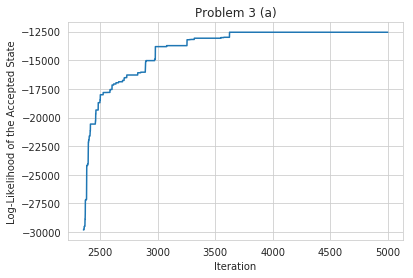

In [127]:
sns.lineplot(y=loglikelihood, x=times)
plt.title("Problem 3 (a)")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood of the Accepted State")
plt.savefig("3a.pdf")

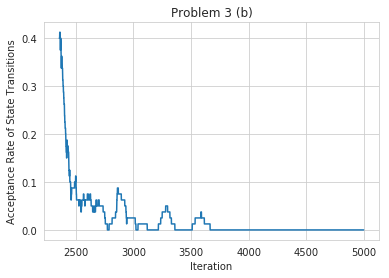

In [128]:
local_accepted = []
T = 40
for i in range(len(accepted)):
    local_accepted.append(np.sum(accepted[max(0, i-T):min(i+T, len(accepted)-1)])/2./T)
sns.lineplot(y=local_accepted, x=times)
plt.title("Problem 3 (b)")
plt.xlabel("Iteration")
plt.ylabel("Acceptance Rate of State Transitions")
plt.savefig("3b.pdf")

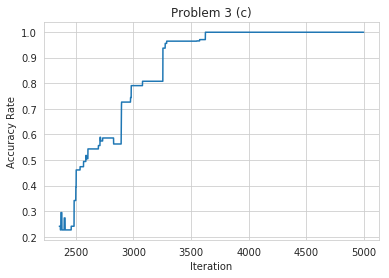

In [129]:
sns.lineplot(y=acc, x=times)
plt.title("Problem 3 (c)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy Rate")
plt.savefig("3c.pdf")

# Run in Small Segments

In [146]:
df = pd.DataFrame({"Segment Length":[], "Accuracy":[]})
df

Empty DataFrame
Columns: [Segment Length, Accuracy]
Index: []

In [144]:
def run(l):
    i, K = l
    con = ciphertext[i:i+K]
    ans = plaintext[i:i+K]
    mcmc = MCMC(alphabet=Alphabet, ciphertext=con, answer=ans)
    times, loglikelihood, acc, accepted = mcmc.run(10000, printacc=False)
    #df.append(pd.DataFrame({"Segment Length":[K], "Accuracy":[acc[-1]]}))
    print(i, K, acc[-1])

l = []
for K in [500, 1000, 1500]:
    for i in range(0, len(ciphertext), K):
        l.append([i, K])
pool = Pool(30)                         # Create a multiprocessing Pool
pool.map(run, l)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp


5000 1000 1.0
5000 500 0.7386759581881533
0 500 0.996
1000 500 0.998
4500 500 0.944
3500 500 0.468
2000 500 1.0
1500 500 0.274
3000 500 1.0
2500 500 0.98
4000 500 0.998
500 500 0.056
1000 1000 1.0
4500 1500 1.0
4000 1000 0.32
3000 1000 0.311
0 1000 0.979
2000 1000 1.0
0 1500 0.998
1500 1500 0.9993333333333333
3000 1500 0.9993333333333333


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [174]:
with open("3d.txt", "r") as f:
    for line in f.readlines():
        segs = line.split()
        df = df.append(pd.DataFrame({"Segment Length":[int(segs[1])], "Accuracy":[float(segs[2])]}))
df["Segment Length"] = np.array(df["Segment Length"]).astype(np.int)
df["Accuracy"] = np.array(df["Accuracy"]).astype(np.float)
df.head()

Segment Length  Accuracy
0            1000  1.000000
0             500  0.738676
0             500  0.996000
0             500  0.998000
0             500  0.944000

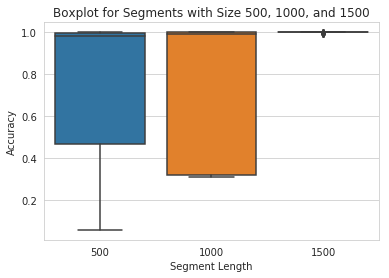

In [177]:
sns.boxplot(x="Segment Length", y="Accuracy", data=df)
plt.title("Boxplot for Segments with Size 500, 1000, and 1500")
plt.savefig("3d.pdf")

In [160]:
list(df)

['Segment Length', 'Accuracy']

# Steady-State Value

In [195]:
loglikelihood[-1]/math.log(2, math.e)/len(ciphertext)

-3.426198665466389

In [189]:
math.log(4, 2)

2.0

In [207]:
H = 0
for i in range(28):
    for j in range(28):
        if(P[i]!=0 and M[j, i]!=0):
            H += (P[i]*M[j, i])*math.log(P[i]*M[j, i])
H

-5.176798462822324

In [191]:
math.log(math.e)

1.0